## Sustainability Project Work

This code will be cleaned up and massaged quite a bit in the final version, but here it is! On time!

by Jenica Andersen

In [57]:
import nltk
nltk.download('punkt')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.util import ngrams
from nltk.corpus import stopwords, wordnet
from nltk.stem import LancasterStemmer, PorterStemmer, SnowballStemmer
from nltk.chunk import ne_chunk
from nltk.tag import pos_tag

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import NMF

np.set_printoptions(suppress=True)

import re
import string

[nltk_data] Downloading package punkt to /Users/vesper/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# Let's get some text to work with
df = pd.read_csv(r'/Users/vesper/Documents/Metis/Module_5_Unsupervised_NLP/Sustainability_Project/shareholder_resolutions_ceres2.csv')
text = df.whereas
print(text)

0       In our Company’s 2021 Sustainability Report, C...
1       We believe in full disclosure of Abbott Labora...
2       The political expenditures of AbbVie Inc. appe...
3       Resolved:\nShareholders request Air Products a...
4       The increasing rate and number of climate rela...
                              ...                        
1107    Resolved:\nShareholders request that Mondelēz ...
1108    Resolved: Shareholders of Mondelez Internation...
1109    we believe in full disclosure of Morgan Stanle...
1110    Motorola Solutions, Inc., a global corporation...
1111    we believe in full disclosure of Motorola Solu...
Name: whereas, Length: 1112, dtype: object


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1112 entries, 0 to 1111
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   status        1112 non-null   object
 1   title         1112 non-null   object
 2   organization  1112 non-null   object
 3   filed_by      1110 non-null   object
 4   year          1112 non-null   int64 
 5   whereas       923 non-null    object
dtypes: int64(1), object(5)
memory usage: 52.2+ KB


In [4]:
df.dropna(subset=['whereas'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 923 entries, 0 to 1111
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   status        923 non-null    object
 1   title         923 non-null    object
 2   organization  923 non-null    object
 3   filed_by      921 non-null    object
 4   year          923 non-null    int64 
 5   whereas       923 non-null    object
dtypes: int64(1), object(5)
memory usage: 50.5+ KB


In [5]:
#remove the special characters from the text column, creating a new column call "preprocessed"
df['preprocessed'] = df.whereas.apply(lambda x: (re.sub(r"[^a-zA-Z0-9 ]", " ", x)))
#and remove the number from the text column
df['preprocessed'] = df.preprocessed.apply(lambda x: (re.sub(r'[0-9]', ' ', x)))
df.head()

,status,title,organization,filed_by,year,whereas,preprocessed
0,Filed,Adopt stewardship practices to reduce diversif...,3M Co.,The Shareholder Commons,2022,"In our Company’s 2021 Sustainability Report, C...",In our Company s Sustainability Report C...
1,Vote,Report on lobbying,Abbott Laboratories,Unitarian Universalist Association,2022,We believe in full disclosure of Abbott Labora...,We believe in full disclosure of Abbott Labora...
2,Vote,Report on lobbying in line with company values...,AbbVie Inc.,As You Sow,2022,The political expenditures of AbbVie Inc. appe...,The political expenditures of AbbVie Inc appe...
3,Withdrawn: Commitment,Adopt GHG reduction targets,Air Products & Chemicals Inc.,The Nathan Cummings Foundation,2022,Resolved:\nShareholders request Air Products a...,Resolved Shareholders request Air Products ad...
4,Withdrawn: Strategic,Adopt GHG reduction targets,Allegheny Technologies Inc.,As You Sow,2022,The increasing rate and number of climate rela...,The increasing rate and number of climate rela...


In [6]:
#now begin to remove stopwords
my_additional_stop_words = ['www', 'whereas', 'include', 'full', 'request', 'resolved','Resolved', 'Shareholders', 'Shareholder', 'shareholder','shareholders', 'company', 'companies','use', 'In', 'We', '"We', '"A"', 'The', 'Our', 'For', 'https', 'http', 'pdf', '"I"', 'one', 'abebafb']
#I may want to add even more of my own stop words to this list.. return to this
stop_words = stopwords.words('english')
stop_words2 = list(stop_words)
for word in my_additional_stop_words:
    stop_words2.append(word)

df['filtered'] = df.preprocessed.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words2)]))
df.head()

,status,title,organization,filed_by,year,whereas,preprocessed,filtered
0,Filed,Adopt stewardship practices to reduce diversif...,3M Co.,The Shareholder Commons,2022,"In our Company’s 2021 Sustainability Report, C...",In our Company s Sustainability Report C...,Company Sustainability Report CEO Mike Roman s...
1,Vote,Report on lobbying,Abbott Laboratories,Unitarian Universalist Association,2022,We believe in full disclosure of Abbott Labora...,We believe in full disclosure of Abbott Labora...,believe disclosure Abbott Laboratories Abbott ...
2,Vote,Report on lobbying in line with company values...,AbbVie Inc.,As You Sow,2022,The political expenditures of AbbVie Inc. appe...,The political expenditures of AbbVie Inc appe...,political expenditures AbbVie Inc appear misal...
3,Withdrawn: Commitment,Adopt GHG reduction targets,Air Products & Chemicals Inc.,The Nathan Cummings Foundation,2022,Resolved:\nShareholders request Air Products a...,Resolved Shareholders request Air Products ad...,Air Products address risks opportunities prese...
4,Withdrawn: Strategic,Adopt GHG reduction targets,Allegheny Technologies Inc.,As You Sow,2022,The increasing rate and number of climate rela...,The increasing rate and number of climate rela...,increasing rate number climate related disaste...


Two ways to turn the resolutions into a corpus for preprocessing and analysis: first way turns it into a single text string, the second turns it into a list of strings where each element in the list is a rsolution. 

In [7]:
corpus = list(df.preprocessed)
type(corpus)
len(corpus)

923

In [8]:
porter = PorterStemmer()
snowball = SnowballStemmer(language = 'english')
lancaster = LancasterStemmer()

In [9]:
df['stemmed'] = df.filtered.apply(lambda x: RegexpTokenizer("\s+", gaps=True).tokenize(x))#' '.join([word for word in x.split() if word not in (stop_words2)]).porter.stem(x))
df['porter'] = df['stemmed'].apply(lambda x: [porter.stem(y) for y in x]) # Stem every word.
df['lancaster'] = df['stemmed'].apply(lambda x: [lancaster.stem(y) for y in x]) # Stem every word.
df['snowball'] = df['stemmed'].apply(lambda x: [snowball.stem(y) for y in x]) # Stem every word.
df.head()

,status,title,organization,filed_by,year,whereas,preprocessed,filtered,stemmed,porter,lancaster,snowball
0,Filed,Adopt stewardship practices to reduce diversif...,3M Co.,The Shareholder Commons,2022,"In our Company’s 2021 Sustainability Report, C...",In our Company s Sustainability Report C...,Company Sustainability Report CEO Mike Roman s...,"[Company, Sustainability, Report, CEO, Mike, R...","[compani, sustain, report, ceo, mike, roman, s...","[company, sustain, report, ceo, mik, rom, stat...","[compani, sustain, report, ceo, mike, roman, s..."
1,Vote,Report on lobbying,Abbott Laboratories,Unitarian Universalist Association,2022,We believe in full disclosure of Abbott Labora...,We believe in full disclosure of Abbott Labora...,believe disclosure Abbott Laboratories Abbott ...,"[believe, disclosure, Abbott, Laboratories, Ab...","[believ, disclosur, abbott, laboratori, abbott...","[believ, disclos, abbot, lab, abbot, direct, i...","[believ, disclosur, abbott, laboratori, abbott..."
2,Vote,Report on lobbying in line with company values...,AbbVie Inc.,As You Sow,2022,The political expenditures of AbbVie Inc. appe...,The political expenditures of AbbVie Inc appe...,political expenditures AbbVie Inc appear misal...,"[political, expenditures, AbbVie, Inc, appear,...","[polit, expenditur, abbvi, inc, appear, misali...","[polit, expendit, abbvy, int, appear, misalign...","[polit, expenditur, abbvi, inc, appear, misali..."
3,Withdrawn: Commitment,Adopt GHG reduction targets,Air Products & Chemicals Inc.,The Nathan Cummings Foundation,2022,Resolved:\nShareholders request Air Products a...,Resolved Shareholders request Air Products ad...,Air Products address risks opportunities prese...,"[Air, Products, address, risks, opportunities,...","[air, product, address, risk, opportun, presen...","[air, produc, address, risk, opportun, pres, c...","[air, product, address, risk, opportun, presen..."
4,Withdrawn: Strategic,Adopt GHG reduction targets,Allegheny Technologies Inc.,As You Sow,2022,The increasing rate and number of climate rela...,The increasing rate and number of climate rela...,increasing rate number climate related disaste...,"[increasing, rate, number, climate, related, d...","[increas, rate, number, climat, relat, disast,...","[increas, rat, numb, clim, rel, disast, affect...","[increas, rate, number, climat, relat, disast,..."


In [10]:
#run this only ONE time to unnest the list in each doc
df['porter'] = df['porter'].apply(lambda x: ' '.join([word for word in x]))
df['lancaster'] = df['lancaster'].apply(lambda x: ' '.join([word for word in x]))
df['snowball'] = df['snowball'].apply(lambda x: ' '.join([word for word in x]))
df

,status,title,organization,filed_by,year,whereas,preprocessed,filtered,stemmed,porter,lancaster,snowball
0,Filed,Adopt stewardship practices to reduce diversif...,3M Co.,The Shareholder Commons,2022,"In our Company’s 2021 Sustainability Report, C...",In our Company s Sustainability Report C...,Company Sustainability Report CEO Mike Roman s...,"[Company, Sustainability, Report, CEO, Mike, R...",compani sustain report ceo mike roman state co...,company sustain report ceo mik rom stat commit...,compani sustain report ceo mike roman state co...
1,Vote,Report on lobbying,Abbott Laboratories,Unitarian Universalist Association,2022,We believe in full disclosure of Abbott Labora...,We believe in full disclosure of Abbott Labora...,believe disclosure Abbott Laboratories Abbott ...,"[believe, disclosure, Abbott, Laboratories, Ab...",believ disclosur abbott laboratori abbott dire...,believ disclos abbot lab abbot direct indirect...,believ disclosur abbott laboratori abbott dire...
2,Vote,Report on lobbying in line with company values...,AbbVie Inc.,As You Sow,2022,The political expenditures of AbbVie Inc. appe...,The political expenditures of AbbVie Inc appe...,political expenditures AbbVie Inc appear misal...,"[political, expenditures, AbbVie, Inc, appear,...",polit expenditur abbvi inc appear misalign pub...,polit expendit abbvy int appear misalign publ ...,polit expenditur abbvi inc appear misalign pub...
3,Withdrawn: Commitment,Adopt GHG reduction targets,Air Products & Chemicals Inc.,The Nathan Cummings Foundation,2022,Resolved:\nShareholders request Air Products a...,Resolved Shareholders request Air Products ad...,Air Products address risks opportunities prese...,"[Air, Products, address, risks, opportunities,...",air product address risk opportun present clim...,air produc address risk opportun pres clim cha...,air product address risk opportun present clim...
4,Withdrawn: Strategic,Adopt GHG reduction targets,Allegheny Technologies Inc.,As You Sow,2022,The increasing rate and number of climate rela...,The increasing rate and number of climate rela...,increasing rate number climate related disaste...,"[increasing, rate, number, climate, related, d...",increas rate number climat relat disast affect...,increas rat numb clim rel disast affect socy c...,increas rate number climat relat disast affect...
...,...,...,...,...,...,...,...,...,...,...,...,...
1107,Vote,Report on supply chain deforestation impacts,"Mondelez International, Inc.",SumOfUS,2019,Resolved:\nShareholders request that Mondelēz ...,Resolved Shareholders request that Mondel z I...,Mondel z International Inc Mondelez report ann...,"[Mondel, z, International, Inc, Mondelez, repo...",mondel z intern inc mondelez report annual ini...,mondel z intern int mondelez report an init ma...,mondel z intern inc mondelez report annual ini...
1108,Vote,Report on pay disparity,"Mondelez International, Inc.",AFL-CIO,2019,Resolved: Shareholders of Mondelez Internation...,Resolved Shareholders of Mondelez Internation...,Mondelez International Inc Company Compensatio...,"[Mondelez, International, Inc, Company, Compen...",mondelez intern inc compani compens committe b...,mondelez intern int company compens commit boa...,mondelez intern inc compani compens committe b...
1109,Vote,Report on lobbying,Morgan Stanley,"Boston Common Asset Management, LLC",2019,we believe in full disclosure of Morgan Stanle...,we believe in full disclosure of Morgan Stanle...,believe disclosure Morgan Stanley direct indir...,"[believe, disclosure, Morgan, Stanley, direct,...",believ disclosur morgan stanley direct indirec...,believ disclos morg stanley direct indirect lo...,believ disclosur morgan stanley direct indirec...
1110,Vote,Nominate human rights expert to board,"Motorola Solutions, Inc.",Episcopal Church,2019,"Motorola Solutions, Inc., a global corporation...",Motorola Solutions Inc a global corporation...,Motorola Solutions Inc global corporation face...,"[Motorola, Solutions, Inc, global, corporation

### Word Cloud

I used a different notebook to do word cloud (word cloud was finicky about which kernal I was using, and didn't work in the pervious kernal. I relyied on the pickled df below.

In [109]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [110]:
df.to_pickle("./stemmed_corpus.pkl") 

In [111]:
df_worcloud = pd.read_pickle("./stemmed_corpus.pkl")

In [112]:
text = " ".join(word for word in df_worcloud.porter)
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text)

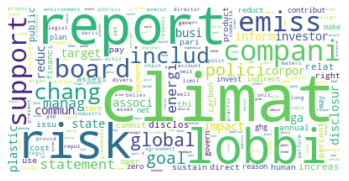

In [113]:
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

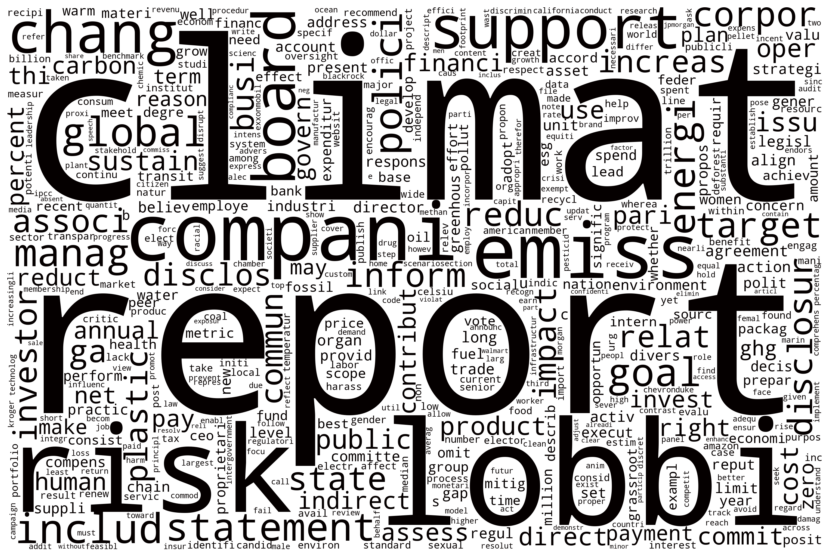

In [114]:
#this code was shared with me by Leaha Nagy, a fellow Metis student.
# change the value to black
def black_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(0,100%, 1%)")
# set the wordcloud background color to white
# set max_words to 1000
# set width and height to higher quality, 3000 x 2000
word_cloud = WordCloud(collocations = False, background_color = 'white',width=3000, height=2000, max_words=500).generate(text)
#wordcloud = WordCloud(font_path = '/Library/Fonts/Arial Unicode.ttf', background_color="white", width=3000, height=2000, max_words=500).generate_from_frequencies(df['porter'])
# set the word color to black
word_cloud.recolor(color_func = black_color_func)
# set the figsize
plt.figure(figsize=[15,10])
# plot the wordcloud
plt.imshow(word_cloud, interpolation="bilinear")
# remove plot axes
plt.axis("off")
# save the image
plt.savefig('word_cloud_all.png')

In [12]:
corpus_port = list(df.porter)
corpus_lanc = list(df.lancaster)
corpus_snow = list(df.snowball)

## Document Term Matrix

In [13]:
indx_label = [e[:100]+"..." for e in df.title]

In [28]:
cv = CountVectorizer(stop_words = 'english', min_df = 6, max_df = .99, ngram_range=(1, 3)) #We have 504 documents, so one document is 0.001984 all of our documents. So to occur in more than one document, a word would need to occur in more than 0.001984% of the documents we have.
X_port = cv.fit_transform(corpus_port)
dtm_port = pd.DataFrame(X_port.toarray(), index=indx_label, columns=cv.get_feature_names())
#dtm.to_csv('dtm_porter.csv')
dtm_port

,ab,abandon,abbvi,abil,abil compet,abil compet adapt,abil comprehens,abil comprehens evalu,abl,abl fulli,...,zero limit warm,zero maintain,zero maintain warm,zero net,zero net deforest,zero order,zero order limit,zero pathway,zero scenario,zero target
Adopt stewardship practices to reduce diversified portfolio ESG costs...,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Report on lobbying...,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Report on lobbying in line with company values/policy...,0,0,12,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Adopt GHG reduction targets...,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Adopt GHG reduction targets...,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Report on supply chain deforestation impacts...,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
Report on pay disparity...,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Report on lobbying...,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Nominate human rights expert to board...,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
cv.get_feature_names()

['ab',
 'abandon',
 'abbvi',
 'abil',
 'abil compet',
 'abil compet adapt',
 'abil comprehens',
 'abil comprehens evalu',
 'abl',
 'abl fulli',
 'abl fulli evalu',
 'abroad',
 'abroad spend',
 'abroad spend lobbi',
 'absenc',
 'absent',
 'absent exampl',
 'absent state',
 'absent studi',
 'absolut',
 'absolut elimin',
 'absolut elimin ton',
 'absolut emiss',
 'absolut emiss energi',
 'absolut emiss reduct',
 'absolut net',
 'absolut net energi',
 'absorb',
 'absorb toxic',
 'absorb toxin',
 'absorb toxin dioxin',
 'abus',
 'academ',
 'academ studi',
 'academi',
 'academi pediatr',
 'acceler',
 'accept',
 'accept platform',
 'accept platform suggest',
 'access',
 'access person',
 'access person document',
 'access pipelin',
 'accompani',
 'accomplish',
 'accord',
 'accord american',
 'accord bank',
 'accord bank climat',
 'accord believ',
 'accord best',
 'accord best avail',
 'accord bloomberg',
 'accord bloomberg new',
 'accord california',
 'accord california transpar',
 'accord gen

In [30]:
nmf = NMF(20, init = "nndsvda")
nmf.fit(dtm_port)

NMF(init='nndsvda', n_components=20)

In [31]:
topic_term = nmf.components_.round(3)
topic_term.shape

(20, 15362)

In [32]:
topic_term_df = pd.DataFrame(topic_term.round(3), columns = cv.get_feature_names())
topic_term_df

,ab,abandon,abbvi,abil,abil compet,abil compet adapt,abil comprehens,abil comprehens evalu,abl,abl fulli,...,zero limit warm,zero maintain,zero maintain warm,zero net,zero net deforest,zero order,zero order limit,zero pathway,zero scenario,zero target
0,0.004,0.023,0.000,0.015,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.012,0.012,0.000,0.000,0.000,0.000,0.000,0.017,0.000
1,0.004,0.000,0.159,0.032,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,0.000,0.000,0.002,0.003,0.000,0.000,0.000,0.000,0.076,0.075,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4,0.000,0.000,0.010,0.009,0.000,0.000,0.000,0.000,0.096,0.000,...,0.016,0.000,0.000,0.256,0.256,0.001,0.004,0.000,0.000,0.000
5,0.010,0.000,0.000,0.026,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.001,0.001,0.000,0.000,0.000,0.000,0.000,0.000,0.000
6,0.001,0.000,0.000,0.103,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
7,0.000,0.000,0.000,0.053,0.009,0.009,0.000,0.000,0.015,0.000,...,0.238,0.000,0.000,0.000,0.000,0.089,0.073,0.000,0.000,0.763
8,0.048,0.002,0.000,0.000,0.000,0.000,0.000,0.000,0.001,0.000,...,0.000,0.024,0.024,0.000,0.000,0.000,0.000,0.000,0.015,0.000
9,0.000,0.000,0.000,0.010,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [33]:
# Function to display the top n terms in each topic
def display_topics(model, feature_names, no_top_words, topic_names = None): 
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix + 1)
        else:
            print("\nTopic: ", topic_names[ix])
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
    print("\n")
    return model, feature_names, no_top_words

In [34]:
output = display_topics(nmf, cv.get_feature_names(), 10)


Topic  1
climat, chang, climat chang, risk, pari, agreement, investor, goal, global, report

Topic  2
lobbi, commun, payment, legisl, indirect, direct, grassroot, indirect lobbi, grassroot lobbi, direct indirect

Topic  3
pay, gap, pay gap, percent, median, women, report, gender, unit, gender pay

Topic  4
compani, corpor, thi, elector, spend, polit, contribut, support, includ, elect

Topic  5
deforest, suppli, chain, suppli chain, risk, includ, report, forest, commod, polici

Topic  6
plastic, packag, recycl, reduc, report, plastic packag, pollut, ocean, plastic pollut, marin

Topic  7
right, human, human right, impact, risk, busi, assess, right impact, human right impact, worker

Topic  8
emiss, target, ghg, reduc, reduct, goal, ghg emiss, scope, set, emiss reduct

Topic  9
energi, climat, renew, chang, climat chang, renew energi, reduc, goal, report, cost

Topic  10
compens, ceo, pay, compani, employe, ceo compens, committe, target, compens committe, execut

Topic  11
fuel, fossil,

In [488]:
display_topics(nmf, cv.get_feature_names(), 5, [
    '1. Climate/net zero emissions/targets', 
    '2. Activism/Lobbying', 
    '3. Female Wage Disparity',
    '4. Plastic Polution and the Ocean', 
    '5. Campaign Contributions', 
    '6. Emissions Targets/zero emissions',
    '7. human rights impact assessments', 
    '8. Paris Agreement/climate change/energy emissions', 
    '9. Financing fossil fuels/warming/ ',
    '10. Compensation review',
    '11. net zero committments fossil fuels',
    '12. Paris Agreement/climate change/energy emissions', 
    '13. esg/sustainability/accountability',
    '14. water use and management',
    '15. climate, climate change',
    '16. natural gas and liquified natural gas',
    '17. plastic pellets polution, chemical spills',
    '18. corporate leaders and accountability',
    '19. gender diversity in tech',
    '20. sexual harassment reporting',

]);#, 'ghg emissions']);
    


Topic:  1. Climate/net zero emissions/targets
climat, emiss, net zero, zero, net

Topic:  2. Activism/Lobbying
lobbi, commun, payment, legisl, indirect

Topic:  3. Female Wage Disparity
pay, gap, pay gap, percent, median

Topic:  4. Plastic Polution and the Ocean
compani, corpor, sharehold, thi, elector

Topic:  5. Campaign Contributions
plastic, pellet, pollut, spill, report

Topic:  6. Emissions Targets/zero emissions
plastic, packag, recycl, plastic packag, reduc

Topic:  7. human rights impact assessments
right, human, human right, impact, risk

Topic:  8. Paris Agreement/climate change/energy emissions
emiss, target, climat, energi, support

Topic:  9. Financing fossil fuels/warming/ 
energi, climat, chang, renew, climat chang

Topic:  10. Compensation review
compens, ceo, pay, compani, employe

Topic:  11. net zero committments fossil fuels
fuel, fossil, fossil fuel, financ, bank

Topic:  12. Paris Agreement/climate change/energy emissions
board, divers, director, sharehold, pol

In [440]:
doc_topic = nmf.transform(dtm_port)
doc_topic.shape

(923, 20)

In [441]:
doc_topic_df = pd.DataFrame(doc_topic.round(5), index = indx_label, columns = [
    '1. Climate/net zero emissions/targets', 
    '2. Activism/Lobbying', 
    '3. Wage Disparity by Gender',
    '4. Plastic Polution and the Ocean', 
    '5. Campaign Contributions', 
    '6. Emissions Targets/zero emissions',
    '7. human rights/impacts/communication', 
    '8. Paris Agreement/climate change/energy emissions', 
    '9. Financing fossil fuels/warming/ ',
    '10. Compensation review',
    '11. net zero committments fossil fuels',
    '12. Paris Agreement/climate change/energy emissions', 
    '13. esg/sustainability/accountability',
    '14. water use and management',
    '15. climate, climate change',
    '16. natural gas and liquified natural gas',
    '17. plastic pellets polution, chemical spills',
    '18. corporate leaders and accountability',
    '19. gender diversity in tech',
    '20. sexual harassment reporting'
])
doc_topic_df

,1. Climate/net zero emissions/targets,2. Activism/Lobbying,3. Wage Disparity by Gender,4. Plastic Polution and the Ocean,5. Campaign Contributions,6. Emissions Targets/zero emissions,7. human rights/impacts/communication,8. Paris Agreement/climate change/energy emissions,9. Financing fossil fuels/warming/,10. Compensation review,11. net zero committments fossil fuels,12. Paris Agreement/climate change/energy emissions,13. esg/sustainability/accountability,14. water use and management,"15. climate, climate change",16. natural gas and liquified natural gas,"17. plastic pellets polution, chemical spills",18. corporate leaders and accountability,19. gender diversity in tech,20. sexual harassment reporting
Adopt stewardship practices to reduce diversified portfolio ESG costs...,0.02380,0.00000,0.00864,0.19184,0.03121,0.03306,0.04710,0.00000,0.00000,0.04869,0.10972,0.05127,0.27855,0.05791,0.30574,0.04732,0.17322,0.14901,0.00000,0.12259
Report on lobbying...,0.00000,1.46654,0.00274,0.00000,0.00080,0.00596,0.00000,0.00000,0.00000,0.00000,0.00000,0.04462,0.00000,0.02041,0.00720,0.04990,0.00000,0.08162,0.00000,0.00000
Report on lobbying in line with company values/policy...,0.00000,0.16229,0.05521,0.19153,0.00000,0.03220,0.06062,0.08589,0.01813,0.00000,0.03135,0.08277,0.07449,0.08417,0.17375,0.13392,0.00000,0.00000,0.00000,0.02503
Adopt GHG reduction targets...,0.14427,0.00000,0.00000,0.00000,0.00000,0.00000,0.02675,0.18237,0.14279,0.03050,0.00000,0.00000,0.00000,0.05406,0.00000,0.00000,0.00000,0.02235,0.09425,0.01257
Adopt GHG reduction targets...,1.10209,0.00000,0.00622,0.00000,0.02168,0.00000,0.01828,0.00000,0.07523,0.00000,0.00000,0.00000,0.00000,0.06239,0.00000,0.00000,0.00683,0.00000,0.12937,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Report on supply chain deforestation impacts...,0.00000,0.00803,0.00000,0.09046,0.01985,0.00000,0.07155,0.00000,0.06644,0.00784,0.00000,0.00000,0.00871,0.91281,0.16397,0.00000,0.00000,0.00000,0.00000,0.00000
Report on pay disparity...,0.00000,0.00000,0.03286,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,2.27382,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
Report on lobbying...,0.00000,2.11264,0.05626,0.01825,0.00000,0.00000,0.00000,0.01696,0.00000,0.00000,0.06594,0.00000,0.00000,0.00000,0.03868,0.00000,0.00000,0.00000,0.00000,0.00000
Nominate human rights expert to board...,0.00460,0.00000,0.00000,0.16098,0.00000,0.00000,1.10519,0.00000,0.00000,0.06400,0.00000,0.56784,0.00000,0.00000,0.00000,0.00000,0.00000,0.06982,0.00000,0.00000


In [420]:
# find the column name of maximum
# values in every row
maxValueIndex = doc_topic_df.idxmax(axis = 1)
 
#print("Max values of row are at following columns :")
#print(maxValueIndex)
maxValueIndex_df = pd.DataFrame(maxValueIndex, columns=['topic'])
maxValueIndex_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 923 entries, Adopt stewardship practices to reduce diversified portfolio ESG costs... to Report on lobbying...
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   topic   923 non-null    object
dtypes: object(1)
memory usage: 14.4+ KB


In [421]:
df.columns

Index(['status', 'title', 'organization', 'filed_by', 'year', 'whereas',
       'preprocessed', 'filtered', 'stemmed', 'porter', 'lancaster',
       'snowball'],
      dtype='object')

In [422]:
left = df.drop(['status', 'filed_by',
       'preprocessed', 'porter'
       ], axis = 1)
left['indx_label'] = [e[:100]+"..." for e in df.title]
left = left.set_index('indx_label')
right = maxValueIndex_df

In [423]:
result = pd.merge(left, right, left_index= True,right_index = True)#, on=[index, index])
result

,title,organization,year,whereas,filtered,stemmed,lancaster,snowball,topic
Adopt GHG reduction targets...,Adopt GHG reduction targets,Air Products & Chemicals Inc.,2022,Resolved:\nShareholders request Air Products a...,Resolved Shareholders request Air Products add...,"[Resolved, Shareholders, request, Air, Product...",resolv sharehold request air produc address ri...,resolv sharehold request air product address r...,8. Paris Agreement/climate change/energy emiss...
Adopt GHG reduction targets...,Adopt GHG reduction targets,Air Products & Chemicals Inc.,2022,Resolved:\nShareholders request Air Products a...,Resolved Shareholders request Air Products add...,"[Resolved, Shareholders, request, Air, Product...",resolv sharehold request air produc address ri...,resolv sharehold request air product address r...,1. Climate/net zero emissions/targets
Adopt GHG reduction targets...,Adopt GHG reduction targets,Air Products & Chemicals Inc.,2022,Resolved:\nShareholders request Air Products a...,Resolved Shareholders request Air Products add...,"[Resolved, Shareholders, request, Air, Product...",resolv sharehold request air produc address ri...,resolv sharehold request air product address r...,1. Climate/net zero emissions/targets
Adopt GHG reduction targets...,Adopt GHG reduction targets,Air Products & Chemicals Inc.,2022,Resolved:\nShareholders request Air Products a...,Resolved Shareholders request Air Products add...,"[Resolved, Shareholders, request, Air, Product...",resolv sharehold request air produc address ri...,resolv sharehold request air product address r...,19. gender diversity in tech
Adopt GHG reduction targets...,Adopt GHG reduction targets,Air Products & Chemicals Inc.,2022,Resolved:\nShareholders request Air Products a...,Resolved Shareholders request Air Products add...,"[Resolved, Shareholders, request, Air, Product...",resolv sharehold request air produc address ri...,resolv sharehold request air product address r...,8. Paris Agreement/climate change/energy emiss...
...,...,...,...,...,...,...,...,...,...
Uncategorized...,Uncategorized,Santander Consumer USA Holdings Inc,2019,Resolved: Shareholders of Santander Consumer U...,Resolved Shareholders Santander Consumer USA H...,"[Resolved, Shareholders, Santander, Consumer, ...",resolv sharehold santand consum us hold int co...,resolv sharehold santand consum usa hold inc c...,4. Plastic Polution and the Ocean
Uncategorized...,Uncategorized,"Tesla, Inc.",2019,shareholders recommend that Tesla Inc. (the Co...,shareholders recommend Tesla Inc Company estab...,"[shareholders, recommend, Tesla, Inc, Company,...",sharehold recommend tesl int company est publ ...,sharehold recommend tesla inc compani establis...,20. sexual harassment reporting
Uncategorized...,Uncategorized,"Tesla, Inc.",2019,shareholders recommend that Tesla Inc. (the Co...,shareholders recommend Tesla Inc Company estab...,"[shareholders, recommend, Tesla, Inc, Company,...",sharehold recommend tesl int company est publ ...,sharehold recommend tesla inc compani establis...,"17. plastic pellets polution, chemical spills"
Uncategorized...,Uncategorized,"Tesla, Inc.",2019,shareholders recommend that Tesla Inc. (the Co...,shareholders recommend Tesla Inc Company estab...,"[shareholders, recommend, Tesla, Inc, Company,...",sharehold recommend tesl int company est publ ...,sharehold recommend tesla inc compani establis...,"17. plastic pellets polution, chemical spills"


**This is what I need to do now:**
 - Decide how I want the word cloud to be (how was it done in the paper?)
 - look at topics by year
 - what story can be told about each topic by year?
 - Look at coherence score for nmf, find optimal (is it) topic numbers?
 - Get code organized and posted on github and submitted
 - look at a company and their resolution with the highest score in each topic
 - Pick one to talk about. What story can be told about that company and that circumstance?
 - Finish, submit and post to github my write up.
 - Finish presentation
 - Practice and record the presentation

In [44]:
porter_list = [' '.join(df['porter'])]
porter_str = ' '
for x in porter_list:
    porter_str += ' ' + x

In [49]:
def word_count(str):
    counts = dict()
    words = str.split()

    for word in words:
        if word in counts:
            counts[word] += 1
        else:
            counts[word] = 1

    return counts

counts = word_count(porter_str)

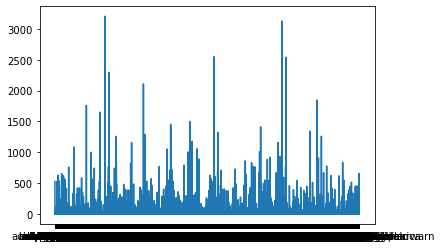

In [56]:
lists = sorted(counts.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.plot(x, y)
plt.show()

In [59]:
sorted_values = sorted(counts.values()) # Sort the values
sorted_dict = {}

for i in sorted_values:
    for k in counts.keys():
        if counts[k] == i:
            sorted_dict[k] = counts[k]
            break

print(sorted_dict)

{'mike': 1, 'grist': 2, 'pursuit': 3, 'blood': 4, 'pfa': 5, 'optim': 6, 'elev': 7, 'roll': 8, 'cumul': 9, 'vision': 10, 'deni': 11, 'gdp': 12, 'fight': 13, 'devic': 14, 'defens': 15, 'ownership': 16, 'block': 17, 'mix': 18, 'grade': 19, 'but': 20, 'rather': 21, 'almost': 22, 'priorit': 23, 'black': 24, 'lobbyist': 25, 'green': 26, 'cours': 27, 'ultim': 28, 'broad': 29, 'feed': 30, 'reveal': 31, 'live': 32, 'near': 33, 'instanc': 34, 'patient': 35, 'tool': 36, 'stop': 37, 'univers': 38, 'extend': 39, 'f': 40, 'page': 41, 'incid': 42, 'i': 43, 'care': 44, 'analyz': 45, 'perspect': 46, 'm': 47, 'whose': 48, 'qualiti': 49, 'back': 50, 'leader': 51, 'controversi': 52, 'medic': 53, 'oppos': 54, 'stem': 55, 'drawn': 56, 'abbvi': 57, 'come': 58, 'around': 59, 'diversifi': 60, 'appear': 61, 'further': 62, 'break': 63, 'figur': 64, 'threat': 65, 'threaten': 66, 'strateg': 67, 'credibl': 68, 'mean': 69, 'acknowledg': 70, 'abil': 71, 'cut': 72, 'ethic': 73, 'life': 74, 'enterpris': 75, 'everi': 76

In [73]:
import operator
#sorted_d = dict( sorted(counts.items(), key=operator.itemgetter(1),reverse=True))
#print('Dictionary in descending order by value : ',sorted_d)
dc = {k: v for k, v in sorted_d.items() if v > 900}
print(dc)

{'climat': 3204, 'report': 3126, 'lobbi': 2550, 'risk': 2538, 'compani': 2291, 'emiss': 2107, 'support': 1847, 'board': 1759, 'chang': 1650, 'includ': 1499, 'global': 1453, 'polici': 1411, 'goal': 1372, 'statement': 1339, 'manag': 1320, 'energi': 1287, 'target': 1259, 'corpor': 1258, 'inform': 1178, 'reduc': 1158, 'disclosur': 1158, 'state': 1126, 'associ': 1084, 'investor': 1056, 'ga': 1053, 'plastic': 1011, 'impact': 1005, 'busi': 1000, 'commun': 977, 'disclos': 940, 'relat': 934, 'increas': 931, 'public': 920, 'sustain': 907}


In [70]:
dc

{'compani': 2291,
 'sustain': 907,
 'report': 3126,
 'state': 1126,
 'associ': 1084,
 'polici': 1411,
 'climat': 3204,
 'chang': 1650,
 'target': 1259,
 'manag': 1320,
 'risk': 2538,
 'global': 1453,
 'commun': 977,
 'increas': 931,
 'reduc': 1158,
 'board': 1759,
 'corpor': 1258,
 'disclosur': 1158,
 'lobbi': 2550,
 'goal': 1372,
 'disclos': 940,
 'includ': 1499,
 'support': 1847,
 'statement': 1339,
 'public': 920,
 'impact': 1005,
 'energi': 1287,
 'busi': 1000,
 'emiss': 2107,
 'relat': 934,
 'investor': 1056,
 'ga': 1053,
 'inform': 1178,
 'plastic': 1011}

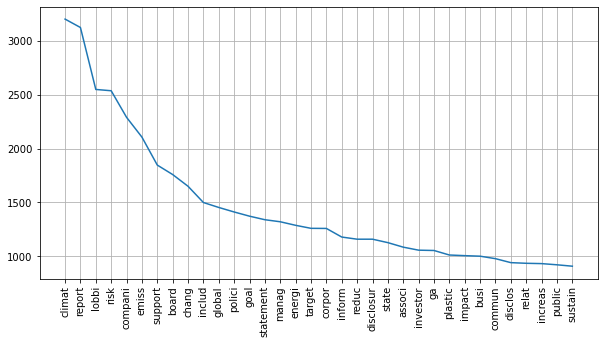

In [89]:
myList = dc.items()
#myList = sorted(myList) 
x, y = zip(*myList) 

plt.figure(figsize=(10, 5))
plt.plot(x, y)
plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 45-degrees
plt.grid()
plt.savefig('wordcount.png')
plt.show();

In [ ]:
import matplotlib.pyplot as plt

data = {'milk': 60, 'water': 10}
names = list(data.keys())
values = list(data.values())

plt.bar(range(len(data)), values, tick_label=names)
plt.show()

In [ ]:
df = pd.DataFrame({
    'X': [1, 2, 3, 4, 5],
    'Y': [2, 4, 6, 10, 15]
})
  
# plotting a line graph
print("Line graph: ")
plt.plot(df["X"], df["Y"])
plt.show()
  
# plotting a scatter plot
print("Scatter Plot:  ")
plt.scatter(df["X"], df["Y"])
plt.show()

In [ ]:
#can compare portland to snowball stemmer
X_snow = cv.fit_transform(corpus_snow)
dtm_snow = pd.DataFrame(X_snow.toarray(), index=indx_label, columns=cv.get_feature_names())
#dtm.to_csv('dtm_porter.csv')
dtm_snow

In [ ]:
#can compare portland to Lancaster stemmer
X_lanc = cv.fit_transform(corpus_lanc)
dtm_lanc = pd.DataFrame(X_lanc.toarray(), index=indx_label, columns=cv.get_feature_names())
#dtm.to_csv('dtm_porter.csv')
dtm_lanc

### (Attempting to get) NMF coherence score

In [107]:
#https://towardsdatascience.com/topic-modeling-articles-with-nmf-8c6b2a227a45
#and 
#https://datascience.oneoffcoder.com/topic-modeling-gensim.html

from gensim.corpora import Dictionary

# Use Gensim's NMF to get the best num of topics via coherence score
#texts = porter_list
#Tokenize the sentence into words
tokens = [word for word in porter_str.split()]

#Create dictionary
dictionary = corpora.Dictionary([tokens])
print(dictionary)


# Create a dictionary
# In gensim a dictionary is a mapping between words and their integer id
#dictionary = Dictionary(texts)

# Filter out extremes to limit the number of features
dictionary.filter_extremes(
    no_below=3,
    no_above=0.85,
    keep_n=5000
)

# Create the bag-of-words format (list of (token_id, token_count))
corpus = [dictionary.doc2bow(token) for token in tokens]

# Create a list of the topic numbers we want to try
topic_nums = list(np.arange(5, 75 + 1, 5))

# Run the nmf model and calculate the coherence score
# for each number of topics
coherence_scores = []

for num in topic_nums:
    nmf = Nmf(
        corpus=corpus,
        num_topics=num,
        id2word=dictionary,
        chunksize=2000,
        passes=5,
        kappa=.1,
        minimum_probability=0.01,
        w_max_iter=300,
        w_stop_condition=0.0001,
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,
        normalize=True,
        random_state=42
    )
    
    # Run the coherence model to get the score
    cm = CoherenceModel(
        model=nmf,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    
    coherence_scores.append(round(cm.get_coherence(), 5))

# Get the number of topics with the highest coherence score
scores = list(zip(topic_nums, coherence_scores))
best_num_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]

print(best_num_topics)

Dictionary<6975 unique tokens: ['a', 'aa', 'aacd', 'aag', 'aar']...>


TypeError: doc2bow expects an array of unicode tokens on input, not a single string

In [108]:
dataset = ['driving car ',
           'drive car carefully',
           'student and university']

# be sure to split sentence before feed into Dictionary
dataset = [d.split() for d in dataset]

vocab = Dictionary(dataset)

list

In [100]:
%matplotlib inline
import matplotlib.pyplot as plt
from collections import defaultdict
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel


In [96]:
# remove common words and tokenize
stoplist = set('for a of the and to in'.split())
texts = [
    [word for word in document.lower().split() if word not in stoplist]
    for document in porter_list
]

# remove words that appear only once
frequency = defaultdict(int)
for text in texts:
    for token in text:
        frequency[token] += 1

texts = [
    [token for token in text if frequency[token] > 1]
    for text in texts
]

In [98]:
#lsi_model = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=2)
#corpus_lsi = lsi_model[corpus_tfidf]
nmf = NMF(20, init = "nndsvda")

cm = CoherenceModel(model=nmf, texts=texts, coherence='c_v')
cm.get_coherence()

AttributeError: 'NMF' object has no attribute 'id2word'

In [ ]:
cm = CoherenceModel(model=lda_model, texts=texts, coherence='c_v')
cm.get_coherence()

*In the feature names, some features or terms are a combination of multiple words. In the next step category, address that somehow. Find out why, and find out how tosplit, or drop words with a length greather than 2 std dev from the average (stemmed?) word length.* 